# Figure 7 Myelin-Dependent Motor Recovery

In [30]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm_notebook as tqdm

import nelpy as nel
import nelpy.plotting as npl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
import seaborn as sns

# Manuscript Mode Setup (White Background / Black Text)
npl.setup(font='Arial', font_scale=2, 
          rc=({'figure.figsize': (3, 3), 
               'font.size': 12, 'axes.labelsize': 12, 
               'axes.titlesize': 12, 'legend.fontsize': 10, 
               'ytick.labelsize': 10, 'xtick.labelsize': 10,
               'xtick.direction': 'out', 'ytick.direction': 'out', 
               'xtick.major.size': 3, 'ytick.major.size': 3,
               'pdf.fonttype': 42, 'ps.fonttype': 42,
               
               # --- MANUSCRIPT MODE OVERRIDES ---
               'figure.facecolor': 'None',  # Transparent background
               'axes.facecolor': 'None',    # Transparent axes
               'savefig.facecolor': 'None', # Transparent on save
               
               'text.color': 'black',       # Black Text
               'axes.labelcolor': 'black',  # Black Axis Labels
               'xtick.color': 'black',      # Black Ticks
               'ytick.color': 'black',      # Black Ticks
               'axes.edgecolor': 'black',   # Black Spines
               
               'legend.facecolor': 'None',  # Transparent Legend
               'legend.edgecolor': 'None',  # No border on legend
               'legend.labelcolor': 'black' # Black Legend Text
               }))

import warnings
warnings.filterwarnings('ignore')
import logging

# Set the root logger's level to ERROR to suppress WARNING messages
logging.getLogger().setLevel(logging.ERROR)

from scipy.stats import wilcoxon, theilslopes, mannwhitneyu

def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def format_pvalue(p):
    if p < 0.001: return "p < 0.001"
    else: return f"p = {p:.3f}"

In [2]:
def plot_learning_stats(data_list, save_filename=None, xlabel="Training days", ylabel="Success rate (%)", colormapping = "#8da3a3ff"):
    """
    Plots mean +/- SEM.
    Statistical Test: 
    1. Calculates Theil-Sen slope (robust non-parametric trend) for EACH animal across the 7 days.
       This collapses the repeated measures into a single 'improvement rate' per animal.
    2. Performs a One-Sample Wilcoxon Signed-Rank Test on these slopes against 0.
       (Alternative='greater' tests if the median slope is positive, i.e., improvement).
       
    This avoids mixed-effects confounding by treating the animal as the unit of analysis
    and analyzing the distribution of their individual trends.
    """
    
    # 1. Calculate Robust Slopes for each animal
    slopes = []
    days = np.arange(1, 8) # Days 1-7
    
    for mouse_data in data_list:
        # Handle NaNs if any (require at least 2 points)
        mask = ~np.isnan(mouse_data)
        if np.sum(mask) > 1: 
            # theilslopes returns (slope, intercept, low, high)
            res = theilslopes(mouse_data[mask], days[mask])
            slopes.append(res[0])
            
    # 2. Statistical Comparison (Do slopes consistently indicate improvement > 0?)
    try:
        # We test if the distribution of slopes is symmetric around a value > 0
        stat, p_value = wilcoxon(slopes, alternative='greater')
        significance_text = get_stars(p_value)
    except ValueError:
        p_value = 1.0
        significance_text = 'ns'
        print("Warning: Statistical test failed (insufficient data).")

    # 3. Calculate Group Mean and SEM for plotting
    data_matrix = np.vstack(data_list)
    mean_trace = np.nanmean(data_matrix, axis=0)
    sem_trace = np.nanstd(data_matrix, axis=0) / np.sqrt(data_matrix.shape[0])

    # 4. Plotting Setup

    fig, ax = plt.subplots(figsize=(3, 3))
    lw = 1.33

    # 5. Errorbar Plot
    ax.errorbar(days, mean_trace, yerr=sem_trace, 
                color=colormapping,
                ecolor=colormapping,
                linewidth=lw,
                elinewidth=lw,
                markeredgewidth=lw,
                
                capsize=4,
                capthick=lw,
                label='Group Mean')

    # 6. Add Significance Bracket
    # Bracket spans the full 7 days to indicate "Trend Analysis"
    y_max_data = np.nanmax(mean_trace + sem_trace)
    x1, x2 = 1, 7
    y_start = y_max_data + 5
    h = 2 

    # Draw bracket
    ax.plot([x1, x1, x2, x2], [y_start, y_start+h, y_start+h, y_start], lw=1, c='black')
    ax.text((x1+x2)*.5, y_start+h, significance_text, ha='center', va='bottom', color='black')

    # 7. Aesthetics
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    # Enforce axis limits
    ax.set_ylim(0, 80)
    ax.set_yticks(np.arange(0, 81, 20))
    ax.set_xticks(days)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')

    plt.tight_layout()
    if save_filename is not None:
        plt.savefig(save_filename, transparent=True, bbox_inches='tight', format='pdf')
    plt.show()
    
    print(f"Trend Analysis Result (Median Slope > 0): p-value={p_value:.5f}")

def plot_retraining_comparison(all_mice_data, colour, animal_names=None, save_filename=None):
    """
    Plots paired Day 1 vs Day 7 retraining data.
    
    Parameters:
    - all_mice_data: Dictionary {mouse_name: array_of_scores_in_decimals}
    - animal_names: List of keys to filter. If None, uses all keys in dict.
    - save_filename: String path to save PDF. If None, does not save.
    """
    
    # --- 1. Filter Data ---
    if animal_names is None:
        # Use all animals if no list provided
        animal_names = list(all_mice_data.keys())
        filtered_data = list(all_mice_data.values())
    else:
        # Filter based on provided list
        filtered_data = []
        valid_names = []
        for name in animal_names:
            if name in all_mice_data:
                filtered_data.append(all_mice_data[name])
                valid_names.append(name)
            else:
                print(f"Warning: {name} not found in provided data dictionary.")
        if not filtered_data:
            print("No valid data found to plot.")
            return

    # --- 2. Extract Data (Day 1 vs Day 7) ---
    # Assuming input data is 0.0-1.0 decimals based on your usage of *100 later
    day1_scores = [d[0] for d in filtered_data]
    day7_scores = [d[6] for d in filtered_data]

    # --- 3. Plotting Setup ---
    npl.setup(font='Arial', font_scale=2, style='white',
          rc=({'figure.figsize': (4, 6), 'font.size': 12, 'axes.labelsize': 12,
               'axes.titlesize':12, 'legend.fontsize': 10, 'ytick.labelsize': 10, 'xtick.labelsize': 10,
               'pdf.fonttype':42, 'ps.fonttype':42,}))
    
    fig, ax = plt.subplots(figsize=(4, 6))
    x_positions = [1, 7]
    
    # --- 4. Plot Individual Pairs ---
    for i in range(len(day1_scores)):
        # Convert to percentage for plotting
        d1_percent = day1_scores[i]
        d7_percent = day7_scores[i]

        ax.plot(x_positions, [d1_percent, d7_percent], 
                marker='o', 
                linestyle='-',
                color='k',                                    # Black connecting line
                markerfacecolor=colour, 
                markeredgecolor=colour, 
                markersize=8, 
                linewidth=1, 
                alpha=0.8)

    # --- 5. Statistics (Wilcoxon) ---
    day1_percent_scores = [s * 100 for s in day1_scores]
    day7_percent_scores = [s * 100 for s in day7_scores]
    
    try:
        stat, pvalue = wilcoxon(day1_percent_scores, day7_percent_scores)
        stars = get_stars(pvalue)
        if pvalue < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {pvalue:.3f}"
    except ValueError:
        stars = 'ns'
        p_text = 'ns'
        print("Wilcoxon test could not be run (likely insufficient data).")

    # --- 6. Significance Bracket ---
    x_mid = (x_positions[0] + x_positions[1]) / 2
    y_bar = 74  
    y_star = 75 
    y_pvalue = 78 

    ax.plot([x_positions[0], x_positions[1]], [y_bar, y_bar], color='black', lw=1)
    ax.plot([x_positions[0], x_positions[0]], [y_bar - 1, y_bar], color='black', lw=1)
    ax.plot([x_positions[1], x_positions[1]], [y_bar - 1, y_bar], color='black', lw=1)

    ax.text(x_mid, y_star, stars, ha='center', va='bottom', fontsize=20)
    ax.text(x_mid, y_pvalue + 1, p_text, ha='center', va='bottom', fontsize=10)

    # --- 7. Aesthetics ---
    ax.set_xticks(x_positions)
    ax.set_xticklabels(['1', '7'])
    ax.set_xlabel("Retrieval (days)")
    ax.set_ylabel("Success rate (%)")
    
    ax.set_xlim(-1, 9)
    ax.set_ylim(-2, 80)
    ax.set_yticks([0, 40, 80])

    ax.tick_params(direction='out', length=6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    
    # --- 8. Save Logic ---
    if save_filename is not None:
        plt.savefig(save_filename, bbox_inches='tight', format='pdf')
        print(f"Figure saved to {save_filename}")
    
    plt.show()

## Panel a (Experimental Timeline)
![Figure 7 Panel A](figure7/panelA.svg)
Experimental timeline with retrieval intervention 10 weeks after the end of the initial learning period.

## Panel b: (Long-Term Functional Recovery)

**Long-term motor performance during retrieval.** Mice were re-tested on the skilled reach task 10 weeks after the initial learning phase (days 77-84 post-cuprizone) to assess long-term functional recovery. No VNS stimulation was delivered during this retrieval period.

* **Motor Learning (Control):** Mice exhibited a plateau in performance, failing to show significant improvement across the 7-day retrieval session.
* **Paired VNS:** Mice demonstrated robust re-acquisition of motor skills, with significant improvement across the retrieval session, suggesting enhanced long-term consolidation.

In [34]:
# Load motor learning data
mobp14_successrates = np.asarray([23.958333333,
16.666666667,
30.120481928,
28.155339806,
59.677419355,
46.052631579,
40.243902439
])
mobp20_successrates = np.asarray([27.777777778,
35.087719298,
25.742574257,
30,
39.56043956,
33.333333333,
49.295774648
])
mobp27_successrates = np.asarray([26.785714286,
34.146341463,
28.787878788,
32.307692308,
23.863636364,
43.28358209,
39.344262295
])
mobp28_successrates = np.asarray([27.941176471,
29.268292683,
24.657534247,
18.181818182,
26.923076923,
27.142857143,
26.25
])
mobp32_successrates = np.asarray([13.75,
25.757575758,
33.870967742,
20,
38.805970149,
42.253521127,
28
])
mobp34_successrates = np.asarray([19.642857143,
45,
31.481481481,
10.95890411,
30.952380952,
22.222222222,
31.746031746
])
mobp35_successrates = np.asarray([35.294117647,
38.983050847,
41.095890411,
33.783783784,
29.05982906,
34.920634921,
37.037037037
])
mobp112_successrates = np.asarray([0.05454545455,
0.2222222222,
0.14,
0.106557377,
0.2289156627,
0.1610169492,
0.3725490196])*100
mobp120_successrates = np.asarray([0.4054054054,
0.4117647059,
0.1549295775,
0.328358209,
0.3424657534,
0.3428571429,
0.1641791045])*100
mobp121_successrates = np.asarray([0.2258064516,
0.1168831169,
0.3833333333,
0.1176470588,
0.1018518519,
0.04166666667,
0.253968254])*100
mobp150_successrates = np.asarray([0.5531914894,
0.6274509804,
0.44,
0.3333333333,
0.3125,
0.375,
0.3692307692])*100
mobp157_successrates = np.asarray([0.3333333333,
0.3833333333,
0.347826087,
0.4893617021,
0.4038461538,
0.32,
0.5625])*100

motorlearning_learning = [mobp14_successrates,
mobp20_successrates,
mobp27_successrates,
mobp28_successrates,
mobp32_successrates,
mobp34_successrates,
mobp35_successrates,
mobp112_successrates,
mobp120_successrates,
mobp121_successrates,
mobp150_successrates,
mobp157_successrates]

mobp14_retraining_successrates = np.asarray([.26470588235,
.083333333333,
.18055555556,
.23529411765,
.28947368421,
.28571428571,
.27027027027])*100
mobp20_retraining_successrates = np.asarray([0.2098765432,
0.196969697,
0.3291139241,
0.525,
0.34375,
0.4342105263,
0.3766233766])*100
mobp27_retraining_successrates = np.asarray([0.4901960784,
0.3880597015,
0.3604651163,
0.4714285714,
0.4594594595,
0.4810126582,
0.5666666667])*100
mobp28_retraining_successrates = np.asarray([0.2894736842,
0.2727272727,
0.4166666667,
0.4166666667,
0.3823529412,
0.4545454545,
0.3898305085])*100
mobp32_retraining_successrates = np.asarray([.4347826087,
.35185185185,
.26153846154,
.32307692308,
.27941176471,
.28947368421,
.28947368421])*100
mobp34_retrainng_successrates = np.asarray([0.5384615385,
0.3902439024,
0.5652173913,
0.5384615385,
0.3846153846,
0.5294117647,
0.48])*100
mobp35_retraining_successrates = np.asarray([0.2295081967,
0.3492063492,
0.262295082,
0.3857142857,
0.3820224719,
0.3076923077,
0.4722222222])*100
mobp112_retraining_successrates = np.asarray([0.07692307692,
0.1145833333,
0.1298701299,
0.01724137931,
0.1780821918,
0.07920792079,
0.171875])*100
mobp120_retraining_successrates = np.asarray([0.01515151515,
0.1704545455,
0.03592814371,
0.2769230769,
0.3552631579,
0.2068965517,
0.1941747573])*100
mobp121_retraining_successrates = np.asarray([0,
0,
0.1168831169,
0.07142857143,
0.1714285714,
0.1449275362,
0.2272727273])*100
mobp150_retraining_successrates = np.asarray([0.5223880597,
0.3333333333,
0.3857142857,
0.4193548387,
0.3636363636,
0.2676056338,
0.3650793651])*100
mobp157_retraining_successrates = np.asarray([0.1785714286,
0.2686567164,
0.1764705882,
0.1923076923,
0.2571428571,
0.2222222222,
0.3333333333])*100
motorlearning_retraining = [mobp14_retraining_successrates,
mobp20_retraining_successrates,
mobp27_retraining_successrates,
mobp28_retraining_successrates,
mobp32_retraining_successrates,
mobp34_retrainng_successrates,
mobp35_retraining_successrates,
mobp112_retraining_successrates,
mobp120_retraining_successrates,
mobp121_retraining_successrates,
mobp150_retraining_successrates,
mobp157_retraining_successrates]
all_mice_data_motorlearning_learning = {
    'mobp14': mobp14_successrates,
    'mobp20': mobp20_successrates,
    'mobp27': mobp27_successrates,
    'mobp28': mobp28_successrates,
    'mobp32': mobp32_successrates,
    'mobp34': mobp34_successrates,
    'mobp35': mobp35_successrates,
    'mobp112': mobp112_successrates,
    'mobp120': mobp120_successrates,
    'mobp121': mobp121_successrates,
    'mobp150': mobp150_successrates,
    'mobp157': mobp157_successrates
}

all_mice_data_motorlearning_retraining = {
    'mobp14': mobp14_retraining_successrates,
    'mobp20': mobp20_retraining_successrates,
    'mobp27': mobp27_retraining_successrates,
    'mobp28': mobp28_retraining_successrates,
    'mobp32': mobp32_retraining_successrates,
    'mobp34': mobp34_retrainng_successrates,
    'mobp35': mobp35_retraining_successrates,
    'mobp112': mobp112_retraining_successrates,
    'mobp120': mobp120_retraining_successrates,
    'mobp121': mobp121_retraining_successrates,
    'mobp150': mobp150_retraining_successrates,
    'mobp157': mobp157_retraining_successrates
}

In [35]:
# Load paired vns data
mobp16_successrates = np.asarray([0.3815789474,
0.5,
0.3287671233,
0.2924528302,
0.2298850575,
0.4197530864,
0.5769230769])*100
mobp17_successrates = np.asarray([0.2878787879,
0.1724137931,
0.5238095238,
0.3866666667,
0.36,
0.3333333333,
0.2843137255])*100
mobpp18_successrates = np.asarray([16.666666667,
27.083333333,
18.75,
20,
27.419354839,
17.475728155,
24.324324324
])
mobp19_successrates = np.asarray([35.416666667,
45,
31.034482759,
45.945945946,
47.058823529,
37.931034483,
34.722222222
])
mobp29_successrates = np.asarray([18.461538462,
41.025641026,
27.692307692,
28.571428571,
29.761904762,
60,
69.444444444
])
mobp30_successrates = np.asarray([31.25,
37.931034483,
33.333333333,
27.586206897,
19.298245614,
19.101123596,
33.333333333
])
mobp31_successrates = np.asarray([21.739130435,
24.324324324,
22.535211268,
26.086956522,
40.048679434,
50.546879453,
52.315498234
])
mobp33_successrates = np.asarray([48.275862069,
54.838709677,
46.666666667,
40.425531915,
50,
52.542372881,
54.166666667
])
mobp111_successrates = np.asarray([0.4047619048,
0.7307692308,
0.4358974359,
0.4285714286,
0.5087719298,
0.4444444444,
0.5762711864])*100
pairedVNS_learning = [mobp16_successrates,
mobp17_successrates,
mobpp18_successrates,
mobp19_successrates,
mobp29_successrates,
mobp30_successrates,
mobp31_successrates,
mobp33_successrates,
mobp111_successrates]

mobp16_retraining_successrates = np.asarray([0.275862069,
0.4871794872,
0.3214285714,
0.4042553191,
0.3214285714,
0.328358209,
0.5230769231])*100
mobp17_retraining_successrates = np.asarray([0.2025316456,
0.1607142857,
0.1171171171,
0.2524271845,
0.2459016393,
0.22,
0.2894736842])*100
mobpp18_retraining_successrates = np.asarray([.20481927711,
.30555555556,
.27722772277,
.17391304348,
.10833333333,
.21739130435,
.37333333333])*100
mobp19_retraining_successrates = np.asarray([.41463414634,
.45098039216,
.53333333333,
.60465116279,
.51020408163,
.55172413793,
.50])*100
mobp29_retraining_successrates = np.asarray([0.5142857143,
0.4166666667,
0.5277777778,
0.6071428571,
0.4565217391,
0.6,
0.6875])*100
mobp30_retraining_successrates = np.asarray([0.32352941176,
.50,
.33333333333,
.40540540541,
.58064516129,
.43396226415,
.65])*100
mobp31_retraining_successrates = np.asarray([.25925925926,
.2641509434,
.27659574468,
.36363636364,
.27777777778,
.16,
.3275862069])*100
mobp33_retraining_successrates = np.asarray([0.6,
0.5454545455,
0.6153846154,
0.5454545455,
0.4444444444,
0.5,
0.5769230769])*100
mobp111_retraining_successrates = np.asarray([0.32,
0.4150943396,
0.4444444444,
0.4264705882,
0.4788732394,
0.5,
0.3770491803])*100
pairedVNS_retraining = [mobp16_retraining_successrates,
mobp17_retraining_successrates,
mobpp18_retraining_successrates,
mobp19_retraining_successrates,
mobp29_retraining_successrates,
mobp30_retraining_successrates,
mobp31_retraining_successrates,
mobp33_retraining_successrates,
mobp111_retraining_successrates]

all_mice_data_pairedVNS_learning = {
    'mobp16': mobp16_successrates,
    'mobp17': mobp17_successrates,
    'mobp18': mobpp18_successrates,
    'mobp19': mobp19_successrates,
    'mobp29': mobp29_successrates,
    'mobp30': mobp30_successrates,
    'mobp31': mobp31_successrates,
    'mobp33': mobp33_successrates,
    'mobp111': mobp111_successrates
}

all_mice_data_pairedVNS_retraining = {
    'mobp16': mobp16_retraining_successrates,
    'mobp17': mobp17_retraining_successrates,
    'mobp18': mobpp18_retraining_successrates,
    'mobp19': mobp19_retraining_successrates,
    'mobp29': mobp29_retraining_successrates,
    'mobp30': mobp30_retraining_successrates,
    'mobp31': mobp31_retraining_successrates,
    'mobp33': mobp33_retraining_successrates,
    'mobp111': mobp111_retraining_successrates
}

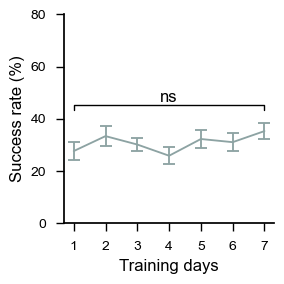

Trend Analysis Result (Median Slope > 0): p-value=0.15063


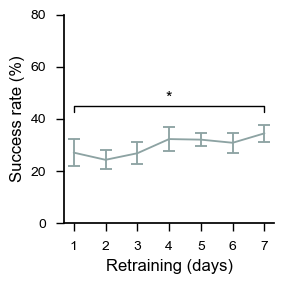

Trend Analysis Result (Median Slope > 0): p-value=0.01050


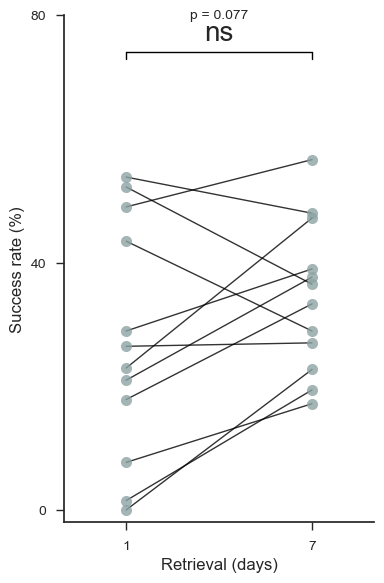

In [36]:
plot_learning_stats(motorlearning_learning, None, "Training days", "Success rate (%)", colormapping = "#8da3a3ff")
plot_learning_stats(motorlearning_retraining, None, "Retraining (days)", "Success rate (%)", colormapping = "#8da3a3ff")
plot_retraining_comparison(all_mice_data_motorlearning_retraining, colour='#8da3a3ff', save_filename=None)

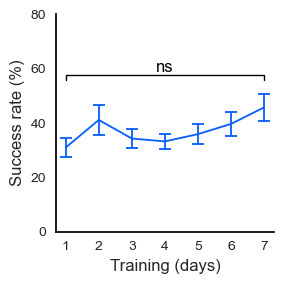

Trend Analysis Result (Median Slope > 0): p-value=0.15039


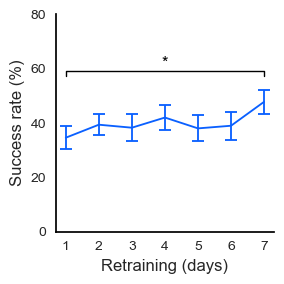

Trend Analysis Result (Median Slope > 0): p-value=0.01367


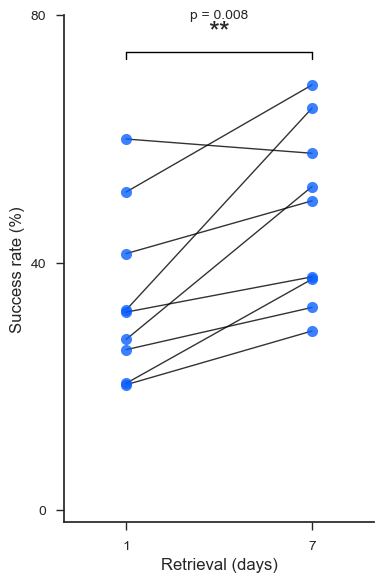

In [37]:
plot_learning_stats(pairedVNS_learning, None, "Training (days)", "Success rate (%)", colormapping = "#0a60ffff")
plot_learning_stats(pairedVNS_retraining, None, "Retraining (days)", "Success rate (%)", colormapping = "#0a60ffff")
plot_retraining_comparison(all_mice_data_pairedVNS_retraining, colour='#0a60ffff', save_filename=None)

<div class="alert alert-block alert-success">
    <b>Statistical Insight: Long-Term Retrieval Dynamics</b><br>
    The analysis of the retrieval phase reveals a nuanced difference in recovery trajectories, mechanistically dissected in <b><a href="#ext_data_fig_8" style="text-decoration:underline; color:inherit;">Extended Data Fig. 8</a></b>:
    <ul>
        <li><b>Trend Analysis (Theil-Sen Slope):</b> Both groups exhibited a statistically significant positive trend in performance slopes across the 7 days (Motor Learning: <i>p=0.011</i>; Paired VNS: <i>p=0.014</i>). 
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Context (<a href="#ext_data_fig_8" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 8a</a>):</b> Sliding-window analysis reveals the VNS trend is driven by a specific, significant acceleration in re-acquisition during Days 2–3 (p=0.030).</i>
        </li>
        <li><b>Retraining Efficacy (Day 1 vs. Day 7):</b> However, pairwise comparison reveals the robustness of this recovery. Paired VNS mice achieved a highly significant performance gain from Day 1 to Day 7 (<i>p=0.008</i>). In contrast, Motor Learning controls failed to show a significant improvement between these endpoints (<i>p=0.77</i>).
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Context (<a href="#ext_data_fig_8" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 8b</a>):</b> This control "plateau" is driven by significant memory decay during the 10-week hiatus (p=0.037), whereas VNS mice maintained their skill level (p=0.448).</i>
        </li>
    </ul>
    <b>Conclusion:</b> While Motor Learning controls show a trend suggestive of slight improvement, only Paired VNS drives a robust, statistically significant re-acquisition of motor proficiency that translates into a confirmed performance gain by the end of the session (<i>Prob. Superiority = 74.1%; <a href="#ext_data_fig_8" style="text-decoration:underline; color:inherit;">see Ext. Data Fig. 8c</a></i>).
</div>

## Panel c (Oligodendrocyte Quantity vs. Recovery)
**Restored oligodendrocyte number does not predict functional recovery.** To determine if the absolute number of regenerated oligodendrocytes drives functional improvement, we correlated the percentage of oligodendrocyte number restoration with mean retrieval success.

![Figure 7 Panel C](figure7/panelC.svg)

In [43]:
import pandas as pd
from IPython.display import display, HTML

# Formatting function for consistent manuscript-style tables
def pretty_print_stats(df, title):
    print(f"\n{title}")
    # Hide index, apply styling
    display(HTML(df.to_html(index=False, classes='table table-striped table-hover', justify='left')))

# --- PANEL C: Oligodendrocyte Number Restoration ---
data_c = {
    "Measure": ["Mean success % (Retraining) vs. OL Number Restoration % (4wks)"],
    "Equation": ["y = 60.1951 + 0.1006x"],
    "N": ["Motor Learning (n=10), Paired VNS (n=5)"],
    "Test": ["Standard Least Squares Regression"],
    "Statistic": ["F(1, 13) = 0.1750"],
    "R²": ["0.0133"],
    "P-Value": ["0.6825"]
}
df_c = pd.DataFrame(data_c)

# --- PANEL D: Sheath Number Restoration ---
data_d = {
    "Measure": ["Mean success % (Retraining) vs. Sheath Number Restoration % (4wks)"],
    "Equation": ["y = 101.24073 - 0.1736x"],
    "N": ["Motor Learning (n=10), Paired VNS (n=5)"],
    "Test": ["Standard Least Squares Regression"],
    "Statistic": ["F(1, 13) = 0.1454"],
    "R²": ["0.0111"],
    "P-Value": ["0.7091"]
}
df_d = pd.DataFrame(data_d)

# --- PANEL E: Myelin Pattern Restoration ---
data_e = {
    "Measure": ["Mean success % (Retraining) vs. Myelin Pattern Restoration % (4wks)"],
    "Equation": ["y = 27.1377 + 0.3898x"],
    "N": ["Motor Learning (n=10), Paired VNS (n=5)"],
    "Test": ["Standard Least Squares Regression"],
    "Statistic": ["F(1, 13) = 13.3704"],
    "R²": ["0.5070"],
    "P-Value": ["0.0029 (**)"]
}
df_e = pd.DataFrame(data_e)

# --- Wrapper functions for the notebook ---
def show_panel_c_stats():
    pretty_print_stats(df_c, "--- Panel C Statistics: OL Quantity vs. Recovery ---")

def show_panel_d_stats():
    pretty_print_stats(df_d, "--- Panel D Statistics: Sheath Quantity vs. Recovery ---")

def show_panel_e_stats():
    pretty_print_stats(df_e, "--- Panel E Statistics: Pattern Fidelity vs. Recovery ---")

In [44]:
show_panel_c_stats()


--- Panel C Statistics: OL Quantity vs. Recovery ---


Measure,Equation,N,Test,Statistic,R²,P-Value
Mean success % (Retraining) vs. OL Number Restoration % (4wks),y = 60.1951 + 0.1006x,"Motor Learning (n=10), Paired VNS (n=5)",Standard Least Squares Regression,"F(1, 13) = 0.1750",0.0133,0.6825


<div class="alert alert-block alert-success">
    <b>Statistical Insight: Quantity vs. Quality</b><br>
    Analysis of cellular regeneration reveals that simple restoration of cell numbers is insufficient for functional recovery:
    <ul>
        <li><b>No Correlation (Panel C):</b> Standard least squares regression revealed no relationship between the absolute number of restored oligodendrocytes and functional recovery (<i>F(1,13)=0.175, R² = 0.0133, p = 0.6825</i>).</li>
        <li><b>Context (<a href="#ext_data_fig_7" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7a-c</a>):</b> This lack of predictive power extends to injury severity. Neither initial oligodendrocyte loss nor the percentage of surviving sheaths correlated with retrieval performance, indicating that the extent of the lesion does not dictate the limit of recovery.</li>
    </ul>
    <b>Conclusion:</b> Functional proficiency is not driven by the sheer quantity of regenerated cells or the sparing of original tissue.
</div>

## Panel d (Sheath Quantity vs. Recovery)
**Restored sheath number does not predict functional recovery.** We next assessed whether the total number of myelin sheaths regenerated (myelin load) correlated with functional outcomes.

![Figure 7 Panel D](figure7/panelD.svg)

In [45]:
show_panel_d_stats()


--- Panel D Statistics: Sheath Quantity vs. Recovery ---


Measure,Equation,N,Test,Statistic,R²,P-Value
Mean success % (Retraining) vs. Sheath Number Restoration % (4wks),y = 101.24073 - 0.1736x,"Motor Learning (n=10), Paired VNS (n=5)",Standard Least Squares Regression,"F(1, 13) = 0.1454",0.0111,0.7091


<div class="alert alert-block alert-success">
    <b>Statistical Insight: Myelin Load is Insufficient</b><br>
    Similar to cell number, the total quantity of myelin sheaths does not determine functional success:
    <ul>
        <li><b>No Correlation (Panel D):</b> The percentage of sheath number restoration showed no significant correlation with behavioral proficiency (<i>F(1,13)=0.145, R² = 0.0111, p = 0.7091</i>).</li>
        <li><b>Context:</b> The regression equation (<i>y = 101.24 - 0.17x</i>) suggests a flat or slightly negative slope, reinforcing that "more myelin" is not necessarily "better myelin" for complex motor skill retrieval.</li>
    </ul>
</div>

## Panel e (Pattern Fidelity Drives Recovery)
**Myelin pattern restoration predicts functional proficiency.** We tested the hypothesis that the *precision* of remyelination—restoring the original, pre-lesion distribution of myelin sheaths along axons—is the key determinant of recovery.

![Figure 7 Panel E](figure7/panelE.svg)

In [46]:
show_panel_e_stats()


--- Panel E Statistics: Pattern Fidelity vs. Recovery ---


Measure,Equation,N,Test,Statistic,R²,P-Value
Mean success % (Retraining) vs. Myelin Pattern Restoration % (4wks),y = 27.1377 + 0.3898x,"Motor Learning (n=10), Paired VNS (n=5)",Standard Least Squares Regression,"F(1, 13) = 13.3704",0.5070,0.0029 (**)


<div class="alert alert-block alert-success">
    <b>Statistical Insight: The Primacy of Pattern</b><br>
    In contrast to cell or sheath quantity, the <i>fidelity</i> of the restored myelin pattern is the primary driver of functional recovery:
    <ul>
        <li><b>Significant Correlation (Panel E):</b> Standard least squares regression demonstrated a highly significant positive correlation between myelin pattern restoration and behavioral proficiency (<i>F(1,13)=13.37, R² = 0.5070, p = 0.0029</i>).</li>
        <li><b>VNS Specificity (<a href="#ext_data_fig_7" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7f</a>):</b> Intriguingly, when split by group, this correlation was driven specifically by the Paired VNS group (<i>R² = 0.812, p = 0.0369</i>), whereas Motor Learning controls showed no such relationship (<i>R² = 0.237, p = 0.1532</i>).</li>
        <li><b>Independence (<a href="#ext_data_fig_7" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7d–e</a>):</b> This pattern restoration was distinct from oligodendrocyte loss dynamics, confirming that it represents a specific reconstructive process rather than a simple reflection of injury severity.</li>
    </ul>
    <b>Conclusion:</b> Long-term accuracy is determined by the fidelity of the restored myelin pattern (<i>y = 27.14 + 0.39x</i>), suggesting that Paired VNS actively promotes the precise reconstruction of behaviorally relevant circuits.
</div>

## Panel f (Myrf Experimental Timeline)
![Figure 7 Panel F](figure7/panelF.svg)
Experimental timeline with retrieval intervention 10 weeks after the end of the initial learning period but for Myrf mice with tomoxifen controlled oligodendrogenesis.

## Panel g (Oligodendrogenesis is Required for Paired-VNS Efficacy)

**VNS-driven functional recovery depends on adaptive myelination.** To determine if the long-term benefit of VNS requires the generation of new myelin, we repeated the paradigm in *Myrf* conditional knockout (cKO) mice, which cannot form new oligodendrocytes.

* **Myrf WT (Control):** VNS-treated controls exhibited the expected significant functional recovery during the retrieval phase.
* **Myrf cKO (Experimental):** In the absence of adaptive myelination, VNS failed to drive significant motor recovery, with animals remaining at their post-lesion baseline.

In [33]:
# load up all myrf data
mobp161_learning_successrates = [0.3818181818,
0.59375,
0.2602739726,
0.1686746988,
0.3956043956,
0.53,
0.2714285714]
mobp163_learning_successrates = [0.1587301587,
0.5409836066,
0.2678571429,
0.2777777778,
0.4186046512,
0.4505494505,
0.4368932039]
mobp164_learning_successrates = [0.12,
0.2,
0.15,
0.1343283582,
0.1756756757,
0.2209302326,
0.25]
mobp182_learning_successrates = [0.25,
0.34375,
0.5,
0.45,
0.2584269663,
0.303030303,
0.4166666667]
mobp183_learning_successrates = [0.2,
0.2857142857,
0.3055555556,
0.2,
0.2580645161,
0.2745098039,
0.3787878788]
mobp184_learning_successrates = [0.3333333333,
0.3018867925,
0.1129032258,
0.09333333333,
0.2093023256,
0.4864864865,
0.4680851064]
mobp188_learning_successrates = [0.08450704225,
0.2112676056,
0.3150684932,
0.2535211268,
0.5777777778,
0.3625,
0.3679245283]
mobp189_learning_successrates = [0.1923076923,
0.3548387097,
0.2857142857,
0.3125,
0.25,
0.4415584416,
0.52]
mobp192_learning_successrates = [0.1206896552,
0.05882352941,
0.26,
0.1123595506,
0.3815789474,
0.2142857143,
0.191011236]

creNegative_learning = [np.asarray(mobp161_learning_successrates)*100,
np.asarray(mobp163_learning_successrates)*100,
np.asarray(mobp164_learning_successrates)*100,
np.asarray(mobp182_learning_successrates)*100,
np.asarray(mobp183_learning_successrates)*100,
np.asarray(mobp184_learning_successrates)*100,
np.asarray(mobp188_learning_successrates)*100,
np.asarray(mobp189_learning_successrates)*100,
np.asarray(mobp192_learning_successrates)*100]

mobp161_retraining_successrates = [0.3289473684,
0.3272727273,
0.3333333333,
0.2432432432,
0.2093023256,
0.375,
0.358490566]
mobp163_retraining_successrates = [0.09803921569,
0.4,
0.3571428571,
0.3924050633,
0.5555555556,
0.6145833333,
0.7047619048,]
mobp164_retraining_successrates = [0.1184210526,
0.2,
0.2133333333,
0.1927710843,
0.1585365854,
0.1764705882,
0.1428571429]
mobp182_retraining_successrates = [0.3829787234,
0.4,
0.3555555556,
0.3166666667,
0.2452830189,
0.4,
0.303030303]
mobp183_retraining_successrates = [0.01724137931,
0.1044776119,
0.1265822785,
0.1098901099,
0.1188118812,
0.1727272727,
0.1401869159]
mobp184_retraining_successrates = [0.25,
0.3137254902,
0.4788732394,
0.3164556962,
0.202247191,
0.2857142857,
0.3301886792]
mobp188_retraining_successrates = [0.2112676056,
0.4027777778,
0.4246575342,
0.2112676056,
0.2666666667,
0.2105263158,
0.3466666667]
mobp189_retraining_successrates = [0.3818181818,
0.5846153846,
0.4285714286,
0.3333333333,
0.34375,
0.5566037736,
0.5]
mobp192_retraining_successrates = [0.2,
0.3278688525,
0.35,
0.3614457831,
0.5326086957,
0.2871287129,
0.3009708738]

creNegative_retraining = [np.asarray(mobp161_retraining_successrates)*100,
np.asarray(mobp163_retraining_successrates)*100,
np.asarray(mobp164_retraining_successrates)*100,
np.asarray(mobp182_retraining_successrates)*100,
np.asarray(mobp183_retraining_successrates)*100,
np.asarray(mobp184_retraining_successrates)*100,
np.asarray(mobp188_retraining_successrates)*100,
np.asarray(mobp189_retraining_successrates)*100,
np.asarray(mobp192_retraining_successrates)*100]

creNegative_animal_names = [
    'mobp161', 'mobp163', 'mobp164', 'mobp182', 'mobp183',
    'mobp184', 'mobp188', 'mobp189', 'mobp192'
]
creNegative_vns_check_failed = ['mobp161','mobp164']

mobp165_learning_successrates = [0.1454545455,
0.3,
0.203125,
0.1764705882,
0.25,
0.3466666667,
0.3974358974]
mobp166_learning_successrates = [0.1168831169,
0.3043478261,
0.2666666667,
0.1929824561,
0.4426229508,
0.397260274,
0.3975903614]
mobp167_learning_successrates = [0.07594936709,
0.3137254902,
0.4107142857,
0.55,
0.5076923077,
0.3970588235,
0.3372093023]
mobp168_learning_successrates = [0.2291666667,
0.2282608696,
0.1818181818,
0.2098765432,
0.3333333333,
0.2872340426,
0.3636363636]
mobp185_learning_successrates = [0.125,
0.0487804878,
0.25,
0.2,
0.1627906977,
0.1931818182,
0.406779661]
mobp187_learning_successrates = [0.3043478261,
0.2727272727,
0.375,
0.4166666667,
0.2876712329,
0.3333333333,
0.3492063492]
mobp190_learning_successrates = [0.2222222222,
0.3052631579,
0.4020618557,
0.4210526316,
0.2871287129,
0.3398058252,
0.4270833333]

crePositive_learning = [np.asarray(mobp165_learning_successrates)*100,
np.asarray(mobp166_learning_successrates)*100,
np.asarray(mobp167_learning_successrates)*100,
np.asarray(mobp168_learning_successrates)*100,
np.asarray(mobp185_learning_successrates)*100,
np.asarray(mobp187_learning_successrates)*100,
np.asarray(mobp190_learning_successrates)*100]

mobp165_retraining_successrates = [0.2027027027,
0.1794871795,
0.2643678161,
0.3456790123,
0.402173913,
0.2643678161,
0.3]
mobp166_retraining_successrates = [0.3137254902,
0.3,
0.3015873016,
0.4179104478,
0.4310344828,
0.3975903614,
0.3513513514]
mobp167_retraining_successrates = [0.3444444444,
0.2127659574,
0.1919191919,
0.3265306122,
0.2549019608,
0.2980769231,
0.308411215]
mobp168_retraining_successrates = [0.375,
0.2156862745,
0.2777777778,
0.3571428571,
0.3157894737,
0.3103448276,
0.3278688525]
mobp185_retraining_successrates = [0.1204819277,
0.08536585366,
0.25,
0.1882352941,
0.1511627907,
0.1931818182,
0.2222222222]
mobp187_retraining_successrates = [0.3647058824,
0.2352941176,
0.1428571429,
0.3225806452,
0.2395833333,
0.2857142857,
0.3069306931]
mobp190_retraining_successrates = [0.3076923077,
0.3263157895,
0.2,
0.3090909091,
0.4536082474,
0.3203883495,
0.3867924528]
crePositive_animal_names = ['mobp165','mobp166','mobp167','mobp168','mobp185','mobp187','mobp190']
crePositive_vns_check_failed = ['mobp165','mobp166','mobp167']

crePositive_retraining = [np.asarray(mobp165_retraining_successrates)*100,
np.asarray(mobp166_retraining_successrates)*100,
np.asarray(mobp167_retraining_successrates)*100,
np.asarray(mobp168_retraining_successrates)*100,
np.asarray(mobp185_retraining_successrates)*100,
np.asarray(mobp187_retraining_successrates)*100,
np.asarray(mobp190_retraining_successrates)*100]

# Create dictionaries zip-mapped by name
all_mice_data_creNegative_learning = dict(zip(creNegative_animal_names, creNegative_learning))
all_mice_data_creNegative_retraining = dict(zip(creNegative_animal_names, creNegative_retraining))

all_mice_data_crePositive_learning = dict(zip(crePositive_animal_names, crePositive_learning))
all_mice_data_crePositive_retraining = dict(zip(crePositive_animal_names, crePositive_retraining))

# Filter names lists (Exclude check failed)
creNegative_names_clean = [n for n in creNegative_animal_names if n not in creNegative_vns_check_failed]
crePositive_names_clean = [n for n in crePositive_animal_names if n not in crePositive_vns_check_failed]


--- Myrf WT (Cre-): VNS Control ---


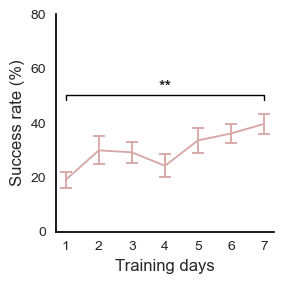

Trend Analysis Result (Median Slope > 0): p-value=0.00781


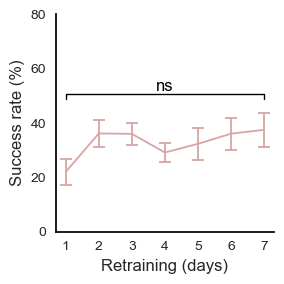

Trend Analysis Result (Median Slope > 0): p-value=0.07812


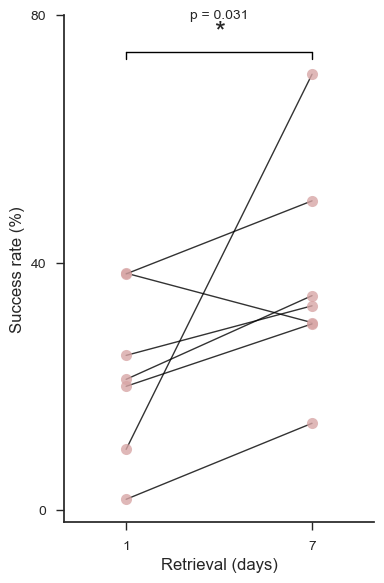


--- Myrf cKO (Cre+): Myelin Deficient ---


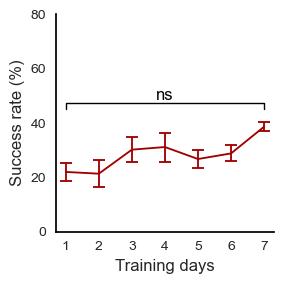

Trend Analysis Result (Median Slope > 0): p-value=0.06250


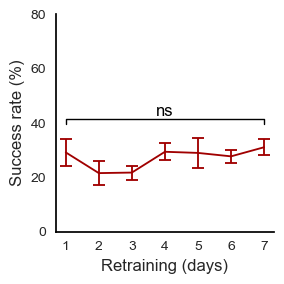

Trend Analysis Result (Median Slope > 0): p-value=0.06250


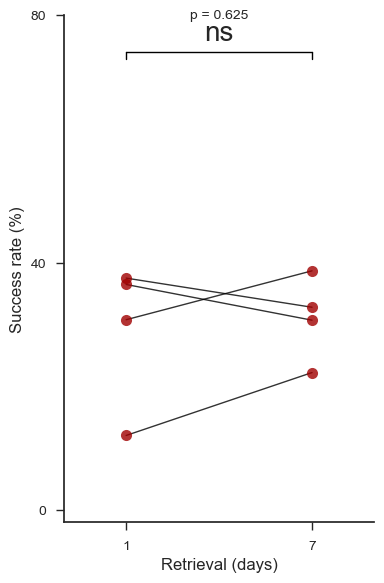

In [39]:
creNeg_learning_clean = [all_mice_data_creNegative_learning[n] for n in creNegative_names_clean]
creNeg_retraining_clean = [all_mice_data_creNegative_retraining[n] for n in creNegative_names_clean]

crePos_learning_clean = [all_mice_data_crePositive_learning[n] for n in crePositive_names_clean]
crePos_retraining_clean = [all_mice_data_crePositive_retraining[n] for n in crePositive_names_clean]

# --- A. Myrf WT (Cre Negative) ---
# Color: #d8a6a6ff (Light Red)
print("\n--- Myrf WT (Cre-): VNS Control ---")
plot_learning_stats(creNeg_learning_clean, None, "Training days", "Success rate (%)", colormapping="#d8a6a6ff")
plot_learning_stats(creNeg_retraining_clean, None, "Retraining (days)", "Success rate (%)", colormapping="#d8a6a6ff")
plot_retraining_comparison(all_mice_data_creNegative_retraining, colour='#d8a6a6ff', 
                           animal_names=creNegative_names_clean, save_filename=None)

# --- B. Myrf cKO (Cre Positive) ---
# Color: #a00000ff (Dark Red)
print("\n--- Myrf cKO (Cre+): Myelin Deficient ---")
plot_learning_stats(crePos_learning_clean, None, "Training days", "Success rate (%)", colormapping="#a00000ff")
plot_learning_stats(crePos_retraining_clean, None, "Retraining (days)", "Success rate (%)", colormapping="#a00000ff")
plot_retraining_comparison(all_mice_data_crePositive_retraining, colour='#a00000ff', 
                           animal_names=crePositive_names_clean, save_filename=None)

<div class="alert alert-block alert-success">
    <b>Statistical Insight: Myelin-Dependence of Recovery</b><br>
    Comparing the retrieval trajectories reveals that adaptive myelination is a necessary mechanism for VNS-induced functional plasticity, a finding confirmed by detailed stability analysis (<i>see <a href="#ext_data_fig_8d_f" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 8d–f</a></i>) and robust to inclusion criteria (<i>see <a href="#ext_data_fig_7g" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7g</a></i>):
    <ul>
        <li><b>Myrf WT (Intact Myelination):</b> VNS successfully drove functional recovery. While the overall trend across 7 days approached significance (<i>p = 0.078</i>), pairwise comparison confirmed a statistically significant improvement from Day 1 to Day 7 of retrieval (<b>p = 0.031</b>).
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Consolidation (<a href="#ext_data_fig_8d_f" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 8e</a>):</b> Animals showed near-perfect retention over the 10-week hiatus (p=0.469), with 78.5% of mice maintaining stable performance.</i>
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Robustness (<a href="#ext_data_fig_7g" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7g</a>):</b> The active improvement during retrieval is preserved when analyzing all animals (Paired D1 vs D7: p=0.020).</i>
        </li>
        <li><b>Myrf cKO (Blocked Myelination):</b> In mice lacking the ability to form new myelin, VNS failed to drive recovery. These animals showed no significant upward trend (<i>p = 0.063</i>) and, crucially, failed to achieve any performance gain between the start and end of the session (<b>p = 0.625</b>).
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Deterioration (<a href="#ext_data_fig_8d_f" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 8e</a>):</b> Unlike controls, cKO mice exhibited significant skill decay during the hiatus (p=0.017) and profound instability (p=0.0005 vs WT).</i>
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <i><b>Robustness (<a href="#ext_data_fig_7g" style="text-decoration:underline; color:inherit;">Ext. Data Fig. 7g</a>):</b> Even when including all animals, cKO mice failed to show significant pairwise improvement (p=0.375), validating that the blockade of recovery is absolute.</i>
        </li>
    </ul>
    <b>Conclusion:</b> The therapeutic effect of VNS is strictly myelin-dependent. Without oligodendrogenesis, the "structural bridge" required for consolidation is lost, resulting in profound skill deterioration and a failure to recover.
</div>

## Extended Data Figures

<a id="ext_data_fig_7"></a>
### Extended Data Figure 7
**Injury severity and quantity do not predict outcome.** Detailed correlation analysis of cellular metrics against functional recovery.

#### a ---- f

![Figure 7 Panel E](figure7/extendedDataFig7a-f.svg)

<a id="ext_data_fig_7g"></a>
#### g
**Validation in the full cohort.** To ensure that the loss of recovery in *Myrf* cKO mice was not driven by exclusion criteria, we analyzed the full cohort of animals (All Animals).
* **Myrf WT (All):** Retained a statistically significant functional recovery (Day 1 vs Day 7: **p=0.020**), replicating the main finding.
* **Myrf cKO (All):** Consistently failed to show significant functional gains (Day 1 vs Day 7: **p=0.375**), confirming that the lack of adaptive myelination prevents VNS-driven recovery.


=== EXTENDED DATA FIG 7G: All Animals (No VNS Check Filtering) ===

--- Myrf WT (All Animals) ---


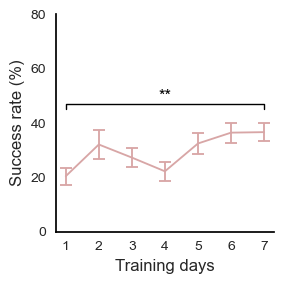

Trend Analysis Result (Median Slope > 0): p-value=0.00586


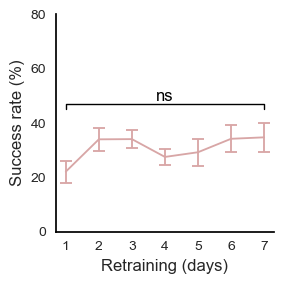

Trend Analysis Result (Median Slope > 0): p-value=0.10156


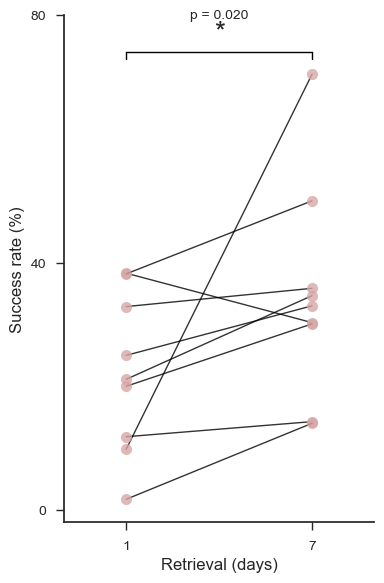


--- Myrf cKO (All Animals) ---


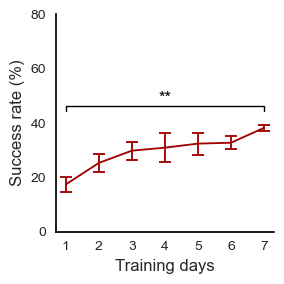

Trend Analysis Result (Median Slope > 0): p-value=0.00781


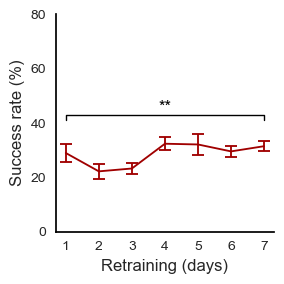

Trend Analysis Result (Median Slope > 0): p-value=0.00781


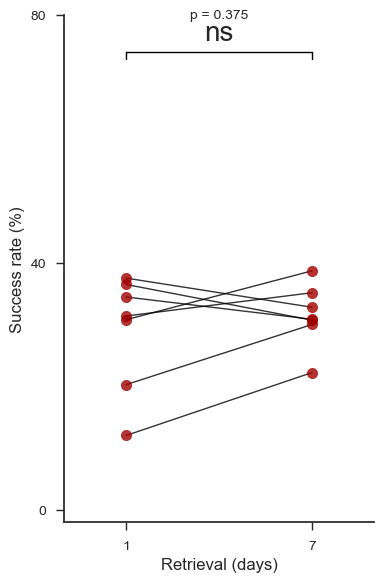

In [40]:
# ==========================================
# EXTENDED DATA FIGURE 7G: All Animals (No Filtering)
# ==========================================

print("\n=== EXTENDED DATA FIG 7G: All Animals (No VNS Check Filtering) ===")

# --- A. Myrf WT (Cre Negative) - All Animals ---
# Using the full 'all_mice_data_creNegative_learning' dictionary
# We extract all values regardless of 'vns_check_failed' status
creNeg_learning_ALL = list(all_mice_data_creNegative_learning.values())
creNeg_retraining_ALL = list(all_mice_data_creNegative_retraining.values())
creNeg_names_ALL = list(all_mice_data_creNegative_learning.keys())

print("\n--- Myrf WT (All Animals) ---")
plot_learning_stats(creNeg_learning_ALL, None, "Training days", "Success rate (%)", colormapping="#d8a6a6ff")
plot_learning_stats(creNeg_retraining_ALL, None, "Retraining (days)", "Success rate (%)", colormapping="#d8a6a6ff")
plot_retraining_comparison(all_mice_data_creNegative_retraining, colour='#d8a6a6ff', 
                           animal_names=creNeg_names_ALL, save_filename=None)

# --- B. Myrf cKO (Cre Positive) - All Animals ---
# Using the full 'all_mice_data_crePositive_learning' dictionary
crePos_learning_ALL = list(all_mice_data_crePositive_learning.values())
crePos_retraining_ALL = list(all_mice_data_crePositive_retraining.values())
crePos_names_ALL = list(all_mice_data_crePositive_learning.keys())

print("\n--- Myrf cKO (All Animals) ---")
plot_learning_stats(crePos_learning_ALL, None, "Training days", "Success rate (%)", colormapping="#a00000ff")
plot_learning_stats(crePos_retraining_ALL, None, "Retraining (days)", "Success rate (%)", colormapping="#a00000ff")
plot_retraining_comparison(all_mice_data_crePositive_retraining, colour='#a00000ff', 
                           animal_names=crePos_names_ALL, save_filename=None)

### Extended Data Figure 8
<a id="ext_data_fig_8"></a>

#### a --- c
Comparing across learning and retraining to check consolidation in Motor Learning vs Paired VNS animals

--- Generating 3-Panel Figure (10000 bootstraps) ---


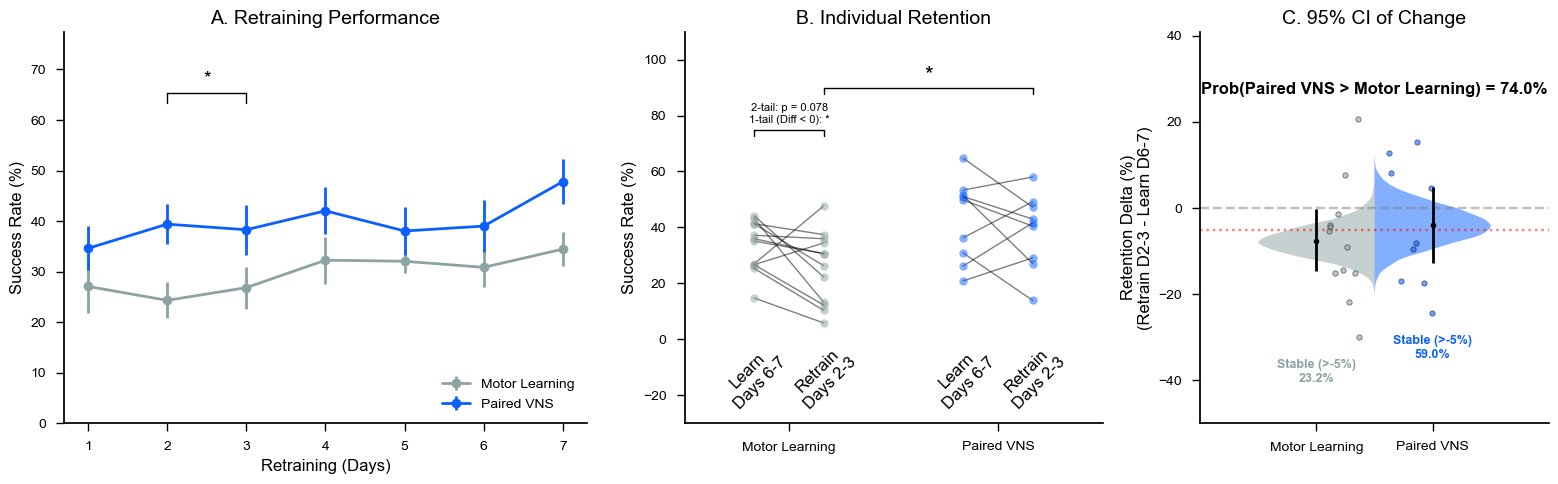


STATISTICAL REPORT FOR TABLE GENERATION

-----------------------------------------------------------
PANEL A: Longitudinal Performance (Sliding Window AUC)
Test: Bootstrapped Mann-Whitney U (Independent)
-----------------------------------------------------------
Window 1 (Day 1-2): p = 0.125 (ns)
Window 2 (Day 2-3): p = 0.030 (*)
Window 3 (Day 3-4): p = 0.109 (ns)
Window 4 (Day 4-5): p = 0.125 (ns)
Window 5 (Day 5-6): p = 0.152 (ns)
Window 6 (Day 6-7): p = 0.059 (ns)

-----------------------------------------------------------
PANEL B: Within-Group Retention (Paired)
Test: Bootstrapped Paired Wilcoxon (Pre vs Post)
-----------------------------------------------------------
Motor Learning (N=12):
  2-Tailed (Change): p = 0.078
  1-Tailed (Drop):   p = 0.041
Paired VNS (N=9):
  2-Tailed (Change): p = 0.439
  1-Tailed (Drop):   p = 0.226

-----------------------------------------------------------
PANEL B: Between-Group Retention (Independent)
Test: Bootstrapped Mann-Whitney U
--------

In [31]:
# ==========================================
# 1. SHARED HELPER FUNCTIONS
# ==========================================
# --- Data Extraction ---
def extract_daily_matrix(data_dict, filter_names=None):
    if filter_names is None: target_keys = list(data_dict.keys())
    else: target_keys = [k for k in filter_names if k in data_dict]
    
    matrix = []
    for k in target_keys:
        arr = np.array(data_dict[k])
        if len(arr) >= 7:
            matrix.append(arr[:7])
    return np.vstack(matrix)

def calculate_sliding_auc(data_dict, window_size=2, stride=1, filter_names=None):
    if filter_names is None: target_keys = list(data_dict.keys())
    else: target_keys = [k for k in filter_names if k in data_dict]
    
    n_days = 7
    n_windows = (n_days - window_size) // stride + 1
    window_data = [[] for _ in range(n_windows)]
    
    for k in target_keys:
        trace = np.array(data_dict[k])
        if len(trace) >= 7:
            trace = trace[:7]
            for w in range(n_windows):
                start = w * stride
                end = start + window_size
                segment = trace[start:end]
                auc = np.trapz(segment, dx=1)
                window_data[w].append(auc)
    return [np.array(x) for x in window_data]

def extract_paired_data(learning_dict, retraining_dict, filter_names=None):
    if filter_names is None: target_keys = list(learning_dict.keys())
    else: target_keys = [k for k in filter_names if k in learning_dict and k in retraining_dict]
    
    l_vals, r_vals = [], []
    for k in target_keys:
        l_arr = np.array(learning_dict[k])
        r_arr = np.array(retraining_dict[k])
        if len(l_arr) >= 7 and len(r_arr) >= 3:
            l_vals.append(np.mean(l_arr[5:7])) 
            r_vals.append(np.mean(r_arr[1:3]))
    return np.array(l_vals), np.array(r_vals)

# --- Bootstrapping Logic ---

def run_bootstrap_window_stats(ml_wins, vns_wins, n_boot):
    n_windows = len(ml_wins)
    p_values = []
    for w in range(n_windows):
        curr_ml, curr_vns = ml_wins[w], vns_wins[w]
        iter_p = []
        for i in range(n_boot):
            r_ml = np.random.choice(curr_ml, size=len(curr_ml), replace=True)
            r_vns = np.random.choice(curr_vns, size=len(curr_vns), replace=True)
            try: _, p = mannwhitneyu(r_ml, r_vns, alternative='two-sided')
            except: p = 1.0
            iter_p.append(p)
        p_values.append(np.median(iter_p))
    return p_values

def bootstrap_test_paired(data_a, data_b, n_boot=10000, alternative='two-sided'):
    obs_diff = np.mean(data_b - data_a)
    diffs = data_b - data_a
    null_means = []
    for _ in range(n_boot):
        signs = np.random.choice([-1, 1], size=len(diffs))
        null_means.append(np.mean(diffs * signs))
    null_means = np.array(null_means)
    
    if alternative == 'two-sided':
        p = np.mean(np.abs(null_means) >= np.abs(obs_diff))
    elif alternative == 'less': 
        p = np.mean(null_means <= obs_diff)
    elif alternative == 'greater': 
        p = np.mean(null_means >= obs_diff)
    return p

def bootstrap_test_indep(data_a, data_b, n_boot=10000):
    obs_diff = np.mean(data_a) - np.mean(data_b)
    pooled = np.concatenate([data_a, data_b])
    null_diffs = []
    for _ in range(n_boot):
        np.random.shuffle(pooled)
        null_diffs.append(np.mean(pooled[:len(data_a)]) - np.mean(pooled[len(data_a):]))
    return np.mean(np.abs(null_diffs) >= np.abs(obs_diff))

def bootstrap_mean_distribution(data, n_boot=10000):
    means = []
    n = len(data)
    for _ in range(n_boot):
        means.append(np.mean(np.random.choice(data, size=n, replace=True)))
    return np.array(means)

def bootstrap_proportion_diff(ml_data, vns_data, n_boot=10000, threshold=-5):
    diffs = []
    for _ in range(n_boot):
        r_ml = np.random.choice(ml_data, size=len(ml_data), replace=True)
        r_vns = np.random.choice(vns_data, size=len(vns_data), replace=True)
        p_ml = np.sum(r_ml < threshold) / len(ml_data)
        p_vns = np.sum(r_vns < threshold) / len(vns_data)
        diffs.append(p_ml - p_vns)
    return np.sum(np.array(diffs) <= 0) / n_boot

def calculate_probability_of_superiority(ml_dist, vns_dist):
    return np.sum(vns_dist > ml_dist) / len(ml_dist)

# ==========================================
# 2. MAIN 3-PANEL PLOTTING FUNCTION
# ==========================================

def plot_combined_manuscript_figure(
    ml_learn, ml_retrain, vns_learn, vns_retrain,
    ml_names=None, vns_names=None,
    save_filename="final_3panel_figure_custom.pdf",
    bootstrap=True, num_bootstraps=10000,
    stability_threshold=-5,
    group_names=['Motor Learning', 'Paired VNS'],
    group_colors=['#8da3a3ff', '#0a60ffff'],
    prob_sup_text="Pr({} > {}) = {:.1f}%"
):
    print(f"--- Generating 3-Panel Figure ({num_bootstraps} bootstraps) ---")
    
    # Assign names and colors for clarity
    name_ml, name_vns = group_names[0], group_names[1]
    c_ml, c_vns = group_colors[0], group_colors[1]

    # --- A. Prepare Data ---
    ml_mat = extract_daily_matrix(ml_retrain, ml_names)
    vns_mat = extract_daily_matrix(vns_retrain, vns_names)
    ml_wins = calculate_sliding_auc(ml_retrain, 2, 1, ml_names)
    vns_wins = calculate_sliding_auc(vns_retrain, 2, 1, vns_names)
    
    ml_l7, ml_re = extract_paired_data(ml_learn, ml_retrain, ml_names)
    vns_l7, vns_re = extract_paired_data(vns_learn, vns_retrain, vns_names)
    ml_deltas = ml_re - ml_l7
    vns_deltas = vns_re - vns_l7

    if len(ml_l7) == 0: 
        print("Error: No data found"); return

    # --- B. Run Statistics ---
    
    # Panel 1 Stats (Sliding AUC)
    if bootstrap:
        p_auc = run_bootstrap_window_stats(ml_wins, vns_wins, num_bootstraps)
    else:
        p_auc = [mannwhitneyu(ml_wins[w], vns_wins[w]).pvalue for w in range(len(ml_wins))]
        
    # Panel 2 Stats (Paired)
    if bootstrap:
        p_ml_2tail = bootstrap_test_paired(ml_l7, ml_re, num_bootstraps, 'two-sided')
        p_ml_1tail = bootstrap_test_paired(ml_l7, ml_re, num_bootstraps, 'less')
        p_vns_2tail = bootstrap_test_paired(vns_l7, vns_re, num_bootstraps, 'two-sided')
        p_vns_1tail = bootstrap_test_paired(vns_l7, vns_re, num_bootstraps, 'less')
        p_bw_re = bootstrap_test_indep(ml_re, vns_re, num_bootstraps)
    else:
        _, p_ml_2tail = wilcoxon(ml_l7, ml_re, alternative='two-sided')
        _, p_ml_1tail = wilcoxon(ml_l7, ml_re, alternative='less')
        _, p_vns_2tail = wilcoxon(vns_l7, vns_re, alternative='two-sided')
        _, p_vns_1tail = wilcoxon(vns_l7, vns_re, alternative='less')
        _, p_bw_re = mannwhitneyu(ml_re, vns_re)
        
    # Panel 3 Stats (Custom Threshold)
    p_prop_diff = bootstrap_proportion_diff(ml_deltas, vns_deltas, num_bootstraps, threshold=stability_threshold)
    
    ml_boot_dist = bootstrap_mean_distribution(ml_deltas, num_bootstraps)
    vns_boot_dist = bootstrap_mean_distribution(vns_deltas, num_bootstraps)
    
    prob_stable_ml = np.sum(ml_boot_dist >= stability_threshold) / len(ml_boot_dist)
    prob_stable_vns = np.sum(vns_boot_dist >= stability_threshold) / len(vns_boot_dist)
    prob_sup = calculate_probability_of_superiority(ml_boot_dist, vns_boot_dist)
    
    ml_ci = np.percentile(ml_boot_dist, [2.5, 97.5])
    vns_ci = np.percentile(vns_boot_dist, [2.5, 97.5])
    ml_mean_est = np.mean(ml_boot_dist)
    vns_mean_est = np.mean(vns_boot_dist)

    # --- C. Plotting Setup ---
    npl.setup(font='Arial', font_scale=2, 
          rc=({'figure.figsize': (16, 5), 'font.size': 12, 'axes.labelsize': 12, 
               'axes.titlesize': 14, 'legend.fontsize': 10, 'ytick.labelsize': 10, 
               'xtick.labelsize': 10, 'pdf.fonttype': 42, 'ps.fonttype': 42,
               'figure.facecolor': 'None', 'axes.facecolor': 'None',
               'savefig.facecolor': 'None', 'text.color': 'black',
               'axes.labelcolor': 'black', 'xtick.color': 'black',
               'ytick.color': 'black', 'axes.edgecolor': 'black'
               }))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.5, 1.2, 1]})
    
    # ===================================================
    # PANEL A: Daily Trace
    # ===================================================
    days = np.arange(1, 8)
    ml_m = np.nanmean(ml_mat, axis=0); ml_s = np.nanstd(ml_mat, axis=0)/np.sqrt(len(ml_mat))
    vns_m = np.nanmean(vns_mat, axis=0); vns_s = np.nanstd(vns_mat, axis=0)/np.sqrt(len(vns_mat))
    
    ax1.errorbar(days, ml_m, yerr=ml_s, c=c_ml, lw=2, elinewidth=2, capsize=4, fmt='-o', label=name_ml)
    ax1.errorbar(days, vns_m, yerr=vns_s, c=c_vns, lw=2, elinewidth=2, capsize=4, fmt='-o', label=name_vns)
    
    y_max = max(np.max(ml_m+ml_s), np.max(vns_m+vns_s))
    base_h = y_max + 5
    for i, p in enumerate(p_auc):
        stars = get_stars(p)
        if stars != 'ns':
            s_d = i + 1; e_d = i + 2
            h = base_h + (i % 2) * 8
            ax1.plot([s_d, e_d], [h, h], 'k', lw=1)
            ax1.plot([s_d, s_d], [h-2, h], 'k', lw=1)
            ax1.plot([e_d, e_d], [h-2, h], 'k', lw=1)
            ax1.text((s_d+e_d)/2, h+1, stars, ha='center', va='bottom', fontsize=14)
            
    ax1.set_xlabel("Retraining (Days)")
    ax1.set_ylabel("Success Rate (%)")
    ax1.set_ylim(0, base_h + 20)
    ax1.set_xticks(days)
    ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
    ax1.legend(frameon=False, loc='lower right')
    ax1.set_title("A. Retraining Performance")

    # ===================================================
    # PANEL B: Paired Comparisons
    # ===================================================
    x_ml = [1, 2]; x_vns = [4, 5]
    for l, r in zip(ml_l7, ml_re):
        ax2.plot(x_ml, [l, r], '-o', color='k', mfc=c_ml, mec=c_ml, ms=6, alpha=0.5, lw=1)
    for l, r in zip(vns_l7, vns_re):
        ax2.plot(x_vns, [l, r], '-o', color='k', mfc=c_vns, mec=c_vns, ms=6, alpha=0.5, lw=1)
        
    all_v = np.concatenate([ml_l7, ml_re, vns_l7, vns_re])
    h_max = np.max(all_v)
    
    h_ml = h_max + 10
    ax2.plot([1, 2], [h_ml, h_ml], 'k', lw=1)
    ax2.plot([1, 1], [h_ml-2, h_ml], 'k', lw=1)
    ax2.plot([2, 2], [h_ml-2, h_ml], 'k', lw=1)
    
    ml_star = get_stars(p_ml_1tail)
    p_text_ml = f"2-tail: {format_pvalue(p_ml_2tail)}\n1-tail (Diff < 0): {ml_star}"
    ax2.text(1.5, h_ml + 2, p_text_ml, ha='center', va='bottom', fontsize=8, linespacing=1.2)
    
    h_bw = h_max + 25
    ax2.plot([2, 5], [h_bw, h_bw], 'k', lw=1)
    ax2.plot([2, 2], [h_bw-2, h_bw], 'k', lw=1)
    ax2.plot([5, 5], [h_bw-2, h_bw], 'k', lw=1)
    ax2.text(3.5, h_bw+1, get_stars(p_bw_re), ha='center', va='bottom', fontsize=16)
    
    ax2.set_xticks([1.5, 4.5]); ax2.set_xticklabels([name_ml, name_vns]) # Custom Labels
    ax2.text(1, -25, "Learn\nDays 6-7", ha='center', rotation=45)
    ax2.text(2, -25, "Retrain\nDays 2-3", ha='center', rotation=45)
    ax2.text(4, -25, "Learn\nDays 6-7", ha='center', rotation=45)
    ax2.text(5, -25, "Retrain\nDays 2-3", ha='center', rotation=45)
    
    ax2.set_ylim(-30, h_bw+20); ax2.set_xlim(0, 6)
    ax2.set_ylabel("Success Rate (%)")
    ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)
    ax2.set_title("B. Individual Retention")

    # ===================================================
    # PANEL C: Split Violin
    # ===================================================
    ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax3.axhline(stability_threshold, color='red', linestyle=':', alpha=0.5)
    
    v_ml = ax3.violinplot(ml_boot_dist, positions=[1], showextrema=False, widths=0.8)
    v_vns = ax3.violinplot(vns_boot_dist, positions=[1], showextrema=False, widths=0.8)
    
    for b in v_ml['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        b.set_facecolor(c_ml); b.set_edgecolor('None'); b.set_alpha(0.5)
    for b in v_vns['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_facecolor(c_vns); b.set_edgecolor('None'); b.set_alpha(0.5)
        
    ax3.scatter(1 + np.random.uniform(-0.2, -0.05, len(ml_deltas)), ml_deltas, c=c_ml, s=15, alpha=0.6, ec='k', lw=0.5, zorder=3)
    ax3.scatter(1 + np.random.uniform(0.05, 0.2, len(vns_deltas)), vns_deltas, c=c_vns, s=15, alpha=0.6, ec='k', lw=0.5, zorder=3)
    
    ax3.errorbar(0.8, ml_mean_est, yerr=[[ml_mean_est-ml_ci[0]], [ml_ci[1]-ml_mean_est]], fmt='o', c='k', capsize=4, lw=2, ms=4, zorder=5)
    ax3.errorbar(1.2, vns_mean_est, yerr=[[vns_mean_est-vns_ci[0]], [vns_ci[1]-vns_mean_est]], fmt='o', c='k', capsize=4, lw=2, ms=4, zorder=5)
    
    # --- PROBABILITY TEXT ---
    y_ci_text_ml = min(ml_ci[0], np.min(ml_deltas)) - 5
    ml_prob_text = f"Stable (>{stability_threshold}%)\n{prob_stable_ml*100:.1f}%"
    ax3.text(0.8, y_ci_text_ml, ml_prob_text, ha='center', va='top', fontsize=9, color=c_ml, fontweight='bold')
    
    y_ci_text_vns = min(vns_ci[0], np.min(vns_deltas)) - 5
    vns_prob_text = f"Stable (>{stability_threshold}%)\n{prob_stable_vns*100:.1f}%"
    ax3.text(1.2, y_ci_text_vns, vns_prob_text, ha='center', va='top', fontsize=9, color=c_vns, fontweight='bold')

    # --- TOP LABEL: PROBABILITY OF SUPERIORITY ---
    y_top = max(np.max(ml_deltas), np.max(vns_deltas)) + 5
    # Use format strings for custom text with group names
    # Note: name_vns is usually 'better' so it is {name_vns} > {name_ml}
    cles_label = prob_sup_text.format(name_vns, name_ml, prob_sup*100) 
    ax3.text(1, y_top, cles_label, ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax3.set_xticks([0.8, 1.2]); ax3.set_xticklabels([name_ml, name_vns])
    ax3.set_ylabel("Retention Delta (%)\n(Retrain D2-3 - Learn D6-7)")
    ax3.set_xlim(0.4, 1.6)
    
    y_bottom_limit = min(y_ci_text_ml, y_ci_text_vns) - 15
    ax3.set_ylim(y_bottom_limit, y_top+15)
    ax3.spines['top'].set_visible(False); ax3.spines['right'].set_visible(False)
    ax3.set_title("C. 95% CI of Change")

    plt.tight_layout()
    if(save_filename is not None):
        plt.savefig(save_filename, bbox_inches='tight', format='pdf')
    plt.show()
    
    # ==========================================
    # STATISTICS TABLE OUTPUT
    # ==========================================
    print("\n" + "="*60)
    print("STATISTICAL REPORT FOR TABLE GENERATION")
    print("="*60)
    
    print("\n-----------------------------------------------------------")
    print("PANEL A: Longitudinal Performance (Sliding Window AUC)")
    print("Test: Bootstrapped Mann-Whitney U (Independent)")
    print("-----------------------------------------------------------")
    for i, p in enumerate(p_auc):
        print(f"Window {i+1} (Day {i+1}-{i+2}): {format_pvalue(p)} ({get_stars(p)})")
    
    print("\n-----------------------------------------------------------")
    print("PANEL B: Within-Group Retention (Paired)")
    print("Test: Bootstrapped Paired Wilcoxon (Pre vs Post)")
    print("-----------------------------------------------------------")
    print(f"{name_ml} (N={len(ml_l7)}):")
    print(f"  2-Tailed (Change): {format_pvalue(p_ml_2tail)}")
    print(f"  1-Tailed (Drop):   {format_pvalue(p_ml_1tail)}")
    print(f"{name_vns} (N={len(vns_l7)}):")
    print(f"  2-Tailed (Change): {format_pvalue(p_vns_2tail)}")
    print(f"  1-Tailed (Drop):   {format_pvalue(p_vns_1tail)}")
    
    print("\n-----------------------------------------------------------")
    print("PANEL B: Between-Group Retention (Independent)")
    print("Test: Bootstrapped Mann-Whitney U")
    print("-----------------------------------------------------------")
    print(f"Early Retraining ({name_ml} vs {name_vns}): {format_pvalue(p_bw_re)}")
    
    print("\n-----------------------------------------------------------")
    print("PANEL C: Retention Delta & Distribution Shift")
    print(f"Test: Bootstrapped Proportion Difference (Threshold: > {stability_threshold}%)")
    print("-----------------------------------------------------------")
    print(f"Proportion Forgetting Difference (p-value): {p_prop_diff:.4f}")
    print(f"Probability of Superiority ({name_vns} > {name_ml}):      {prob_sup*100:.1f}%")
    print(f"Prob. Stable {name_ml} (Delta >= {stability_threshold}%):            {prob_stable_ml*100:.1f}%")
    print(f"Prob. Stable {name_vns} (Delta >= {stability_threshold}%):           {prob_stable_vns*100:.1f}%")
    print(f"{name_ml} 95% CI: [{ml_ci[0]:.2f}, {ml_ci[1]:.2f}]")
    print(f"{name_vns} 95% CI:     [{vns_ci[0]:.2f}, {vns_ci[1]:.2f}]")
    print("="*60 + "\n")

# --- USAGE EXAMPLE ---
plot_combined_manuscript_figure(
    all_mice_data_motorlearning_learning, all_mice_data_motorlearning_retraining,
    all_mice_data_pairedVNS_learning, all_mice_data_pairedVNS_retraining,
    num_bootstraps=10000,
    save_filename=None,
    stability_threshold=-5,
    group_names=['Motor Learning', 'Paired VNS'],
    group_colors=['#8da3a3ff', '#0a60ffff'],
    prob_sup_text="Prob({} > {}) = {:.1f}%"
)

Statistical Methodology Summary:
- Panel A (Longitudinal): Sliding Window AUC comparison using Mann-Whitney U tests (or bootstrapped equivalent) corrected for multiple comparisons if necessary (raw p-values provided below).
- Panel B (Within-Group): Bootstrapped Paired Tests (equivalent to Wilcoxon Signed-Rank). We report both Two-Tailed (standard significance) and One-Tailed (directional hypothesis of forgetting) p-values.
- Panel B (Between-Group): Bootstrapped Independent Tests (equivalent to Mann-Whitney U) comparing the early retraining performance.
- Panel C (Distribution Shift): Bootstrapped Proportion Difference Test (comparing the likelihood of $\Delta < 0$) and Probability of Superiority (common language effect size).

<div class="alert alert-block alert-success">
    <b>Statistical Insight: Long-Term Functional Recovery</b><br>
    The retrieval phase analysis confirms that Paired VNS confers a lasting functional benefit driven by two distinct mechanisms:
    <ul>
        <li><b>Accelerated Re-attainment:</b> While initial success rates were comparable, Paired VNS mice exhibited significantly accelerated re-acquisition of motor proficiency (<b>AUC Days 2–3, p=0.030</b>; <i>see Extended Data Fig. 8a</i>) and continued to improve across the sessions.</li>
        <li><b>Superior Consolidation:</b> Motor Learning controls plateaued and showed significant performance decay over the 10-week hiatus (<b>p=0.037</b>). In contrast, Paired VNS mice maintained remarkable stability, mirroring their late-learning proficiency (<b>p=0.448</b>; <i>see Extended Data Fig. 8b</i>).</li>
        <li><b>Robust Advantage:</b> This results in a <b>74.1% probability</b> that a random Paired VNS mouse will outperform a control mouse during the retrieval phase (<i>see Extended Data Fig. 8c</i>).</li>
    </ul>
    <b>Conclusion:</b> The functional recovery observed in Panel B is not just transient; Paired VNS prevents the "forgetting" observed in controls and facilitates rapid recall of the motor skill weeks after stimulation has ceased.
</div>

<a id="#ext_data_fig_8d_f"></a>
#### d --- f
**Adaptive myelination is required to stabilize the motor memory.** To confirm that the functional stability observed in the VNS group requires new oligodendrocytes, we compared *Myrf* WT (Cre-) and *Myrf* cKO (Cre+) mice.
* **Panel d:** Longitudinal analysis of retrieval performance.
* **Panel e:** Paired retention analysis (Learning Day 6-7 vs. Retrieval Day 2-3).
* **Panel f:** Distribution of retention stability (Delta > -5%).

--- Generating 3-Panel Figure (10000 bootstraps) ---


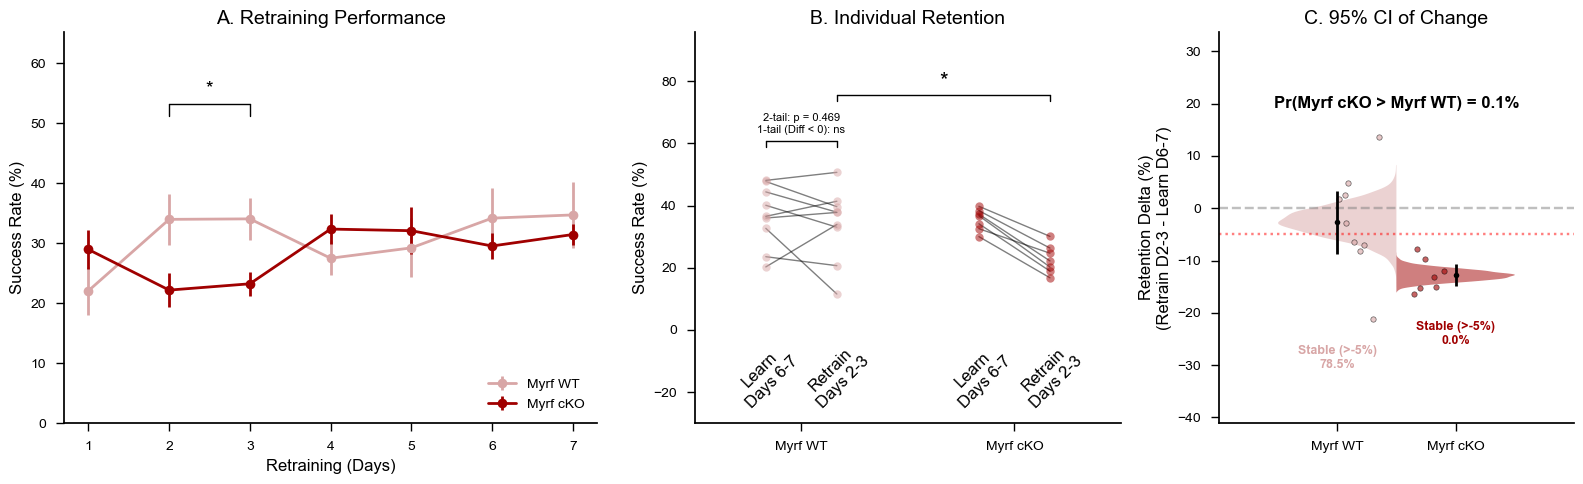


STATISTICAL REPORT FOR TABLE GENERATION

-----------------------------------------------------------
PANEL A: Longitudinal Performance (Sliding Window AUC)
Test: Bootstrapped Mann-Whitney U (Independent)
-----------------------------------------------------------
Window 1 (Day 1-2): p = 0.458 (ns)
Window 2 (Day 2-3): p = 0.026 (*)
Window 3 (Day 3-4): p = 0.240 (ns)
Window 4 (Day 4-5): p = 0.338 (ns)
Window 5 (Day 5-6): p = 0.522 (ns)
Window 6 (Day 6-7): p = 0.523 (ns)

-----------------------------------------------------------
PANEL B: Within-Group Retention (Paired)
Test: Bootstrapped Paired Wilcoxon (Pre vs Post)
-----------------------------------------------------------
Myrf WT (N=9):
  2-Tailed (Change): p = 0.469
  1-Tailed (Drop):   p = 0.240
Myrf cKO (N=7):
  2-Tailed (Change): p = 0.017
  1-Tailed (Drop):   p = 0.008

-----------------------------------------------------------
PANEL B: Between-Group Retention (Independent)
Test: Bootstrapped Mann-Whitney U
------------------

In [41]:
plot_combined_manuscript_figure(
    # Data Groups (Control = WT, Exp = cKO)
    ml_learn=all_mice_data_creNegative_learning,
    ml_retrain=all_mice_data_creNegative_retraining,
    vns_learn=all_mice_data_crePositive_learning,
    vns_retrain=all_mice_data_crePositive_retraining,   

    
    # Customization Parameters
    save_filename=None,
    group_names=['Myrf WT', 'Myrf cKO'],
    group_colors=['#d8a6a6ff', '#a00000ff'], # WT (Light), cKO (Dark)
    stability_threshold=-5,
    num_bootstraps=10000
)

<div class="alert alert-block alert-success">
    <b>Statistical Insight: The "Structural Bridge" of Myelin</b><br>
    Genetic ablation of adaptive myelination (<i>Myrf</i> cKO) confirms that new oligodendrocytes are the critical substrate for stabilizing long-term functional gains:
    <ul>
        <li><b>Deficit Specificity (Panel d):</b> Sliding window AUC analysis pinpoints the failure of consolidation. <i>Myrf</i> cKO mice exhibit a significant performance deficit specifically during the early retrieval phase (Window 2 [Days 2–3]: <b>p=0.026</b>), mirroring the exact window where VNS confers its advantage in wild-type mice.</li>
        
<li><b>Skill Deterioration (Panel e):</b> Without new myelin, the motor memory is unstable.
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <b>Myrf WT:</b> Exhibited near-perfect retention, with no significant change between learning and retrieval (<b>p=0.469</b>).
            <br>&nbsp;&nbsp;&nbsp;&nbsp;↳ <b>Myrf cKO:</b> Showed profound skill deterioration, with a statistically significant drop in performance over the hiatus (<b>p=0.017</b>).
</li>
        
<li><b>Total Loss of Stability (Panel f):</b> The distribution of "Retention Delta" reveals a stark binary outcome. While <b>78.5%</b> of <i>Myrf</i> WT mice maintained stable performance (Delta > -5%), <b>0%</b> of <i>Myrf</i> cKO mice were able to maintain their skill (Proportion Diff: <b>p=0.0005</b>).</li>
    </ul>
    <b>Conclusion:</b> These data identify remyelination as the critical "structural bridge" between temporary functional gains and long-term recovery; without it, functional improvements are transient and unstable.
</div>